In [1]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
np.logspace(np.log10(80),np.log10(178),10)

array([ 80.        ,  87.43437519,  95.55962457, 104.43995085,
       114.1455231 , 124.75303116, 136.34629167, 149.01691027,
       162.86500554, 178.        ])

In [3]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #[0,1] 
freq_range_str_arr = [[33.5,75],[80,178],[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

# define frequency ranges
buffer = 2000 # time in ms to buffer trials (for Morlet)

plot_error_bars = True

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [4]:
# np.shape(dd_trials['ripple'])
# np.shape(dd_trials['raw'])
# dd_trials.keys()
# np.unique(dd_trials['elec_labels'])

In [5]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        start_cutoff = 300 # times (in s) relative to word_on 
        end_cutoff = 1300 
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
        start_cutoff = -1000
        end_cutoff = 0      
        
    # convert time ranges to samples
    sr_factor = 1000/fs
    # data taken is from -1.7 to 3.3 s from word_on so account for that by adding 1700 ms
    start_cutoff = 0
    end_cutoff = 2500 # just take the whole range of data to better estimate Morlet
#     start_cutoff = int((1700+start_cutoff-buffer)/sr_factor) # this comes to 0:2500 anyway
#     end_cutoff = int((1700+end_cutoff+buffer)/sr_factor)     # ...so just index in time from here
    
    
    print("Generating figures for run_mode: ", encoding_mode)
    # starts with high and moves to low
    power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


Generating figures for run_mode:  1


In [15]:
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'clust', 'correct', 'position', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

(18408, 1500)

(18408, 2500)

(4, 18408, 250)

[[33.5, 75], [80, 178], [2, 4], [7, 9]]

array(['R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'], dtype='<U6')

In [16]:
gamma_sd_thresh = 2.0

# select a patient
patient_idx = -1
if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])
      
sub_ripples = dd_trials['ripple'][sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
sub_Zs = power_z[:,sub_idxs,:]
np.shape(sub_Zs)
ripple_start = 300 # time in ms
ripple_end = 1300 # time in ms

ripple_trials = np.sum(sub_ripples[:,int((700+ripple_start)/sr_factor):int((700+ripple_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(sub_idxs),2)}% of total')

z_factor = sr_factor*10 # z_score was decimated 10x
# average z-score over time for same range as ripples
ripple_time_range = slice(int((1700+ripple_start)/z_factor),int((1700+ripple_end)/z_factor))
z_low_gamma_trials = np.mean(sub_Zs[0,:,ripple_time_range],1)>gamma_sd_thresh
z_high_gamma_trials = np.mean(sub_Zs[1,:,ripple_time_range],1)>gamma_sd_thresh

Number of trials: 18408 from the following subs:


array(['R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'], dtype='<U6')

(4, 18408, 250)

5473 trials have ripples which is 29.73% of total


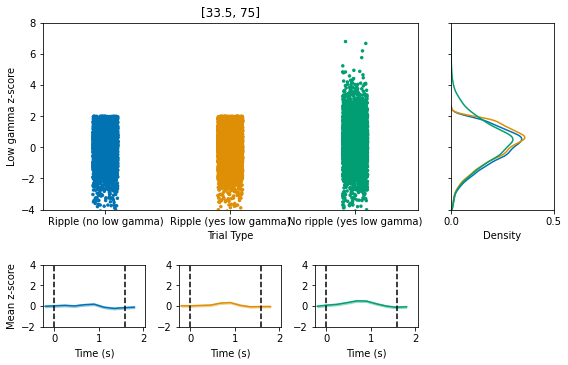

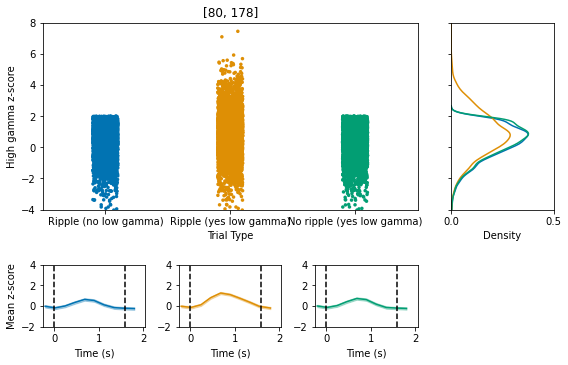

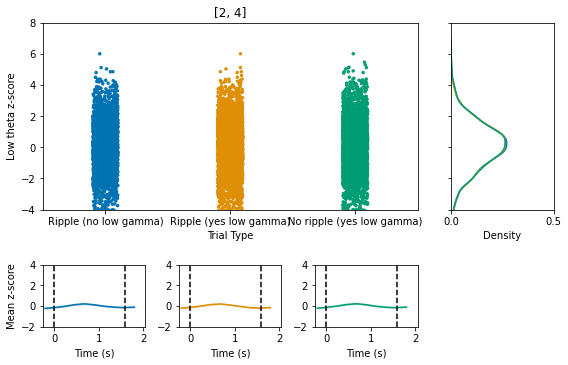

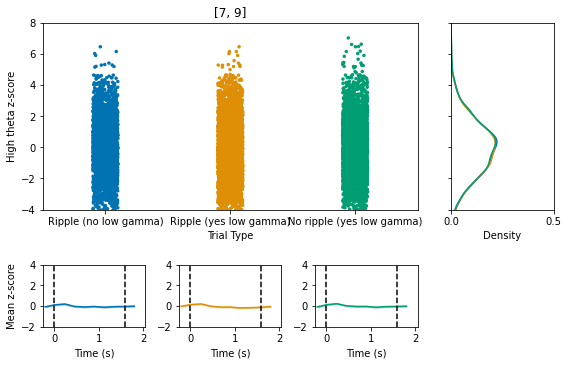

In [60]:
import seaborn as sb
from scipy.signal import decimate
import matplotlib.gridspec as gridspec

# Set the time range for x-axis for mean over time (ripple_time_range handles the time range for the swarm)
time_bins = np.linspace(-0.2, 2.0, 100)  # 100 bins from -0.2 to 2.0 seconds
swarm_ylimits = [-4.0, 8.0]
mean_ylimits = [-2.0, 4.0]

# Also make plots over time for same data
plot_time_range = slice(int((1700 + ripple_start - 500) / z_factor), int((1700 + ripple_end + 500) / z_factor))

for i_freq,freq_range in enumerate(freq_range_str_arr):

    if 29 < freq_range[0] < 35:
        ylabel = 'Low gamma z-score'
    elif 65 < freq_range[0] < 90:
        ylabel = 'High gamma z-score' 
    elif 1 < freq_range[0] < 3:
        ylabel = 'Low theta z-score'
    elif 6 < freq_range[0] < 8:
        ylabel = 'High theta z-score'

    # Extract the data for each group
    swarm_one_idx = ripple_trials & ~z_low_gamma_trials & ~z_high_gamma_trials
    swarm_two_idx = ripple_trials & ~z_low_gamma_trials
    swarm_three_idx = ripple_trials & ~z_high_gamma_trials
    swarm_one = sub_Zs[i_freq, swarm_one_idx, ripple_time_range].mean(axis=1)
    swarm_two = sub_Zs[i_freq, swarm_two_idx, ripple_time_range].mean(axis=1)
    swarm_three = sub_Zs[i_freq, swarm_three_idx, ripple_time_range].mean(axis=1)

    # Combine the data into a single array
    data_combined = np.concatenate([swarm_one, swarm_two, swarm_three])

    # Create labels for each group
    labels = (['Ripple (no low gamma)'] * len(swarm_one) +
              ['Ripple (yes low gamma)'] * len(swarm_two) +
              ['No ripple (yes low gamma)'] * len(swarm_three))

    # Colors for each group
    palette = sb.color_palette("colorblind", 3)

    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(8, 8))  # Overall figure size
    gs = gridspec.GridSpec(4, 4, height_ratios=[3, 1, 1, 1])  # Swarm plot is 3x as tall

    # Create the swarmplot (span all 3 columns)
    ax_swarm = fig.add_subplot(gs[0, :3])
#     sb.swarmplot(x=labels, y=data_combined, palette=palette, size=3.5)  
    sb.stripplot(x=labels, y=data_combined, palette=palette, size=3.5) 
    ax_swarm.set_ylabel(ylabel)
    ax_swarm.set_xlabel('Trial Type')
    ax_swarm.set_ylim(swarm_ylimits)
    ax_swarm.set_title(freq_range) #unique_subs[patient_idx])
    
    # Create the KDE plot next to the stripplot (in the 5th column)
    ax_kde = fig.add_subplot(gs[0, 3])
    sb.kdeplot(y=swarm_one, ax=ax_kde, color=palette[0])
    sb.kdeplot(y=swarm_two, ax=ax_kde, color=palette[1])
    sb.kdeplot(y=swarm_three, ax=ax_kde, color=palette[2])
    ax_kde.set_ylim(swarm_ylimits)
    ax_kde.set_ylabel('')
    ax_kde.set_yticklabels('') #([0, 0.5, 1])  # Set the desired tick positions
    ax_kde.set_xlabel('Density')  # Add label to the bottom of the KDE plot
    ax_kde.set_xticks([0, 0.5, 1])  # Set the desired tick positions
    ax_kde.set_xlim(0,0.5)  # Set the corresponding labels


    # Function to calculate mean and SE
    def mean_and_se(data):
        mean = data.mean(axis=0)
        se = data.std(axis=0) / np.sqrt(data.shape[0])
        return mean, se

    # Decimate time bins
    decimation_factor = 10
    time_bins_decimated = decimate(time_bins, decimation_factor)
    plot_time_range_decimated = slice(None, None, decimation_factor)

    # Plot for swarm one
    mean_swarm_one, se_swarm_one = mean_and_se(sub_Zs[i_freq, swarm_one_idx, plot_time_range])
    mean_swarm_one_decimated = decimate(mean_swarm_one, decimation_factor)
    se_swarm_one_decimated = decimate(se_swarm_one, decimation_factor)

    ax_swarm_one = fig.add_subplot(gs[1, 0])  # Span the first 4 columns
    ax_swarm_one.plot(time_bins_decimated, mean_swarm_one_decimated, label='', color=palette[0])
    ax_swarm_one.fill_between(time_bins_decimated, mean_swarm_one_decimated - se_swarm_one_decimated,
                               mean_swarm_one_decimated + se_swarm_one_decimated, alpha=0.3, color=palette[0])
    ax_swarm_one.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_one.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_one.set_ylabel('Mean z-score')
    ax_swarm_one.set_xlabel('Time (s)')
    ax_swarm_one.set_xlim(-0.25, 2.05)
    ax_swarm_one.set_ylim(mean_ylimits)

    # Plot for swarm two
    mean_swarm_two, se_swarm_two = mean_and_se(sub_Zs[i_freq, swarm_two_idx, plot_time_range])
    mean_swarm_two_decimated = decimate(mean_swarm_two, decimation_factor)
    se_swarm_two_decimated = decimate(se_swarm_two, decimation_factor)

    ax_swarm_two = fig.add_subplot(gs[1, 1])  # Span the first 4 columns
    ax_swarm_two.plot(time_bins_decimated, mean_swarm_two_decimated, label='', color=palette[1])
    ax_swarm_two.fill_between(time_bins_decimated, mean_swarm_two_decimated - se_swarm_two_decimated,
                                  mean_swarm_two_decimated + se_swarm_two_decimated, alpha=0.3, color=palette[1])
    ax_swarm_two.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_two.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_two.set_xlabel('Time (s)')
    ax_swarm_two.set_xlim(-0.25, 2.05)
    ax_swarm_two.set_ylim(mean_ylimits)

    # Plot for swarm three
    mean_swarm_three, se_swarm_three = mean_and_se(sub_Zs[i_freq, swarm_three_idx, plot_time_range])
    mean_swarm_three_decimated = decimate(mean_swarm_three, decimation_factor)
    se_swarm_three_decimated = decimate(se_swarm_three, decimation_factor)

    # Plot for swarm three (occupy 1/4th width)
    ax_swarm_three = fig.add_subplot(gs[1, 2])  # Third column
    ax_swarm_three.plot(time_bins_decimated, mean_swarm_three_decimated, label='', color=palette[2])
    ax_swarm_three.fill_between(time_bins_decimated, mean_swarm_three_decimated - se_swarm_three_decimated,
                                   mean_swarm_three_decimated + se_swarm_three_decimated, alpha=0.3, color=palette[2])
    ax_swarm_three.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_three.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_three.set_xlabel('Time (s)')
    ax_swarm_three.set_xlim(-0.25, 2.05)
    ax_swarm_three.set_ylim(mean_ylimits)

    # Remove y-labels from all but the first plot
    ax_swarm_two.set_ylabel('')
    ax_swarm_three.set_ylabel('')

    # Adjust layout to ensure the plots align correctly
    plt.tight_layout(h_pad=2)
    plt.show()
a=1;


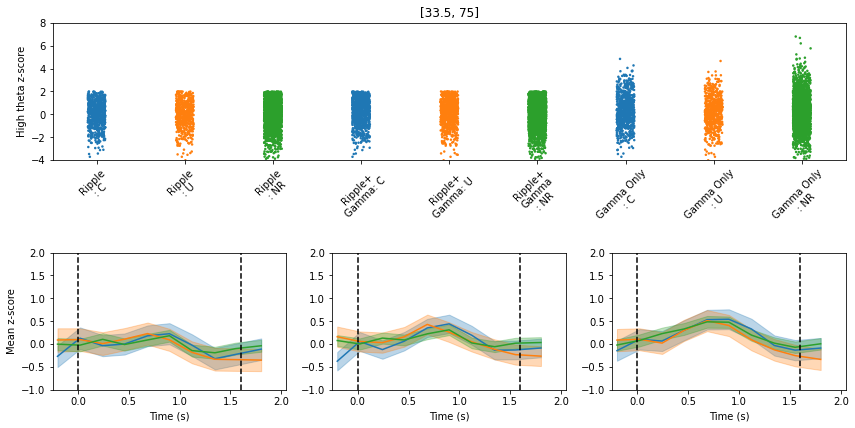

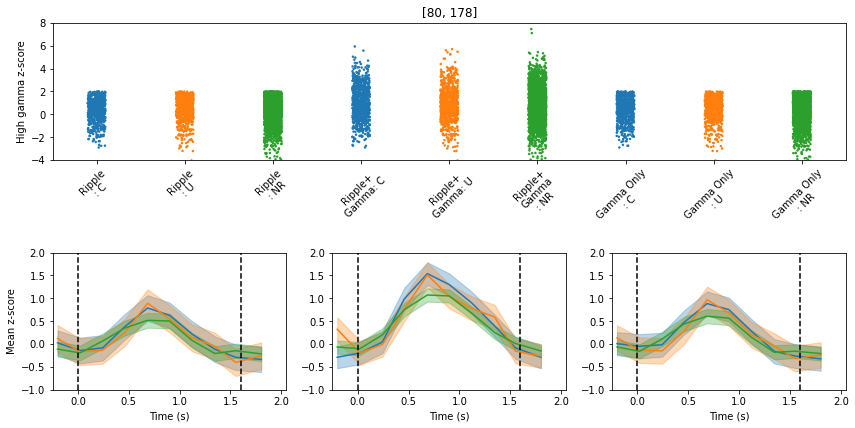

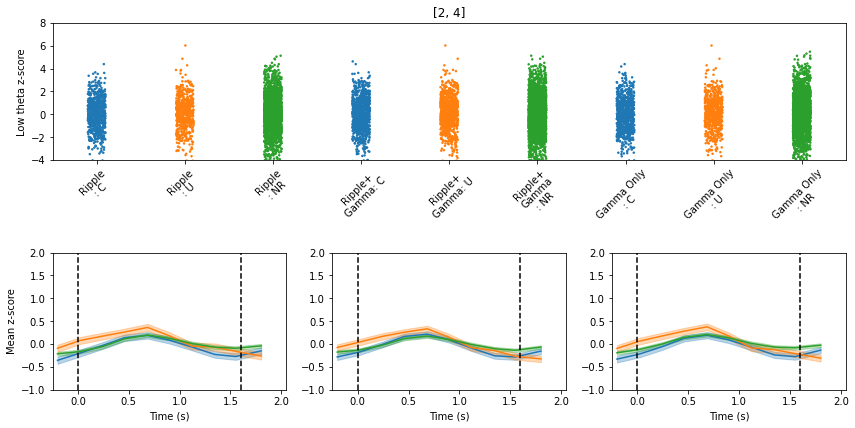

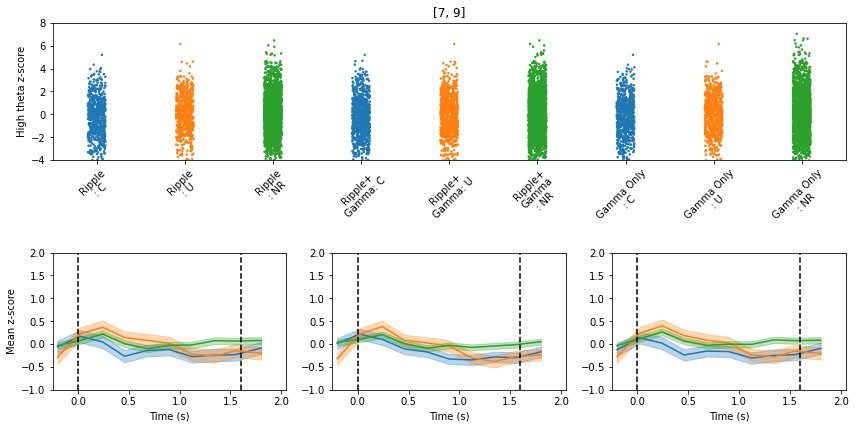

In [23]:
# Set the time range for x-axis for mean over time (ripple_time_range handles the time range for the swarm)
time_bins = np.linspace(-0.2, 2.0, 100)  # 100 bins from -0.2 to 2.0 seconds
swarm_ylimits = [-4.0, 8.0]
mean_ylimits = [-1.0, 2.0]

clust = dd_trials['clust_int'][sub_idxs]

# Define a consistent color palette
palette = {
    'Clustered': '#1f77b4',  # Blue
    'Unclustered': '#ff7f0e',  # Orange
    'Not Recalled': '#2ca02c'  # Green
}

for i_freq,freq_range in enumerate(freq_range_str_arr):

    if 29 < freq_range[0] < 30:
        ylabel = 'Low gamma z-score'
    elif 65 < freq_range[0] < 90:
        ylabel = 'High gamma z-score' 
    elif 1 < freq_range[0] < 3:
        ylabel = 'Low theta z-score'
    elif 6 < freq_range[0] < 8:
        ylabel = 'High theta z-score'

    # Extract the data for each group
    swarm_one_idx = ripple_trials & ~z_low_gamma_trials & ~z_high_gamma_trials
    swarm_two_idx = ripple_trials & ~z_low_gamma_trials
    swarm_three_idx = ripple_trials & ~z_high_gamma_trials

    # Apply the clust variable to split data into clustered, unclustered, and not recalled
    clust_clustered = clust > 1
    clust_unclustered = clust < 0
    clust_not_recalled = clust == 0

    # Combine the data for swarm one (Ripple (no low gamma))
    swarm_one_clustered = sub_Zs[i_freq, swarm_one_idx & clust_clustered, ripple_time_range].mean(axis=1)
    swarm_one_unclustered = sub_Zs[i_freq, swarm_one_idx & clust_unclustered, ripple_time_range].mean(axis=1)
    swarm_one_not_recalled = sub_Zs[i_freq, swarm_one_idx & clust_not_recalled, ripple_time_range].mean(axis=1)

    # Combine the data for swarm two (Ripple (yes low gamma))
    swarm_two_clustered = sub_Zs[i_freq, swarm_two_idx & clust_clustered, ripple_time_range].mean(axis=1)
    swarm_two_unclustered = sub_Zs[i_freq, swarm_two_idx & clust_unclustered, ripple_time_range].mean(axis=1)
    swarm_two_not_recalled = sub_Zs[i_freq, swarm_two_idx & clust_not_recalled, ripple_time_range].mean(axis=1)

    # Combine the data for swarm three (No ripple (yes low gamma))
    swarm_three_clustered = sub_Zs[i_freq, swarm_three_idx & clust_clustered, ripple_time_range].mean(axis=1)
    swarm_three_unclustered = sub_Zs[i_freq, swarm_three_idx & clust_unclustered, ripple_time_range].mean(axis=1)
    swarm_three_not_recalled = sub_Zs[i_freq, swarm_three_idx & clust_not_recalled, ripple_time_range].mean(axis=1)

    # Combine the data into a single array for swarm plots
    data_combined = np.concatenate([swarm_one_clustered, swarm_one_unclustered, swarm_one_not_recalled,
                                    swarm_two_clustered, swarm_two_unclustered, swarm_two_not_recalled,
                                    swarm_three_clustered, swarm_three_unclustered, swarm_three_not_recalled])

    # Create simplified labels for each group
    labels = (['Ripple\n: C'] * len(swarm_one_clustered) +
              ['Ripple\n: U'] * len(swarm_one_unclustered) +
              ['Ripple\n: NR'] * len(swarm_one_not_recalled) +
              ['Ripple+\nGamma: C'] * len(swarm_two_clustered) +
              ['Ripple+\nGamma: U'] * len(swarm_two_unclustered) +
              ['Ripple+\nGamma\n: NR'] * len(swarm_two_not_recalled) +
              ['Gamma Only\n: C'] * len(swarm_three_clustered) +
              ['Gamma Only\n: U'] * len(swarm_three_unclustered) +
              ['Gamma Only\n: NR'] * len(swarm_three_not_recalled))

    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(12, 12))  # Overall figure size
    gs = gridspec.GridSpec(4, 3, height_ratios=[2, 2, 2, 2])  # Mean z-score plots are 2x as tall as the swarm plot

    # Create the swarmplot (span all 3 columns)
    ax_swarm = fig.add_subplot(gs[0, :])
#     sb.swarmplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], size=2.5)  
    sb.stripplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], size=2.5, jitter=True)

    
    ax_swarm.set_ylabel(ylabel)
    ax_swarm.set_xlabel('')
    ax_swarm.set_ylim(swarm_ylimits)
    ax_swarm.set_title(freq_range) #unique_subs[patient_idx])
    ax_swarm.set_xticklabels(ax_swarm.get_xticklabels(), rotation=45, ha="center")

    # Function to calculate mean and SE
    def mean_and_se(data):
        mean = data.mean(axis=0)
        se = data.std(axis=0) / np.sqrt(data.shape[0])
        return mean, se

    # Decimate time bins
    decimation_factor = 10
    time_bins_decimated = decimate(time_bins, decimation_factor)
    plot_time_range_decimated = slice(None, None, decimation_factor)

    # Plot for swarm one
    mean_swarm_one_clustered, se_swarm_one_clustered = mean_and_se(sub_Zs[i_freq, swarm_one_idx & clust_clustered, plot_time_range])
    mean_swarm_one_unclustered, se_swarm_one_unclustered = mean_and_se(sub_Zs[i_freq, swarm_one_idx & clust_unclustered, plot_time_range])
    mean_swarm_one_not_recalled, se_swarm_one_not_recalled = mean_and_se(sub_Zs[i_freq, swarm_one_idx & clust_not_recalled, plot_time_range])

    ax_swarm_one = fig.add_subplot(gs[1, 0])  # Ripple plot
    ax_swarm_one.plot(time_bins_decimated, decimate(mean_swarm_one_clustered, decimation_factor), label='Clustered', color=palette['Clustered'])
    ax_swarm_one.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_one_clustered, decimation_factor) - decimate(se_swarm_one_clustered, decimation_factor),
                              decimate(mean_swarm_one_clustered, decimation_factor) + decimate(se_swarm_one_clustered, decimation_factor), 
                              alpha=0.3, color=palette['Clustered'])
    ax_swarm_one.plot(time_bins_decimated, decimate(mean_swarm_one_unclustered, decimation_factor), label='Unclustered', color=palette['Unclustered'])
    ax_swarm_one.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_one_unclustered, decimation_factor) - decimate(se_swarm_one_unclustered, decimation_factor),
                              decimate(mean_swarm_one_unclustered, decimation_factor) + decimate(se_swarm_one_unclustered, decimation_factor), 
                              alpha=0.3, color=palette['Unclustered'])
    ax_swarm_one.plot(time_bins_decimated, decimate(mean_swarm_one_not_recalled, decimation_factor), label='Not Recalled', color=palette['Not Recalled'])
    ax_swarm_one.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_one_not_recalled, decimation_factor) - decimate(se_swarm_one_not_recalled, decimation_factor),
                              decimate(mean_swarm_one_not_recalled, decimation_factor) + decimate(se_swarm_one_not_recalled, decimation_factor), 
                              alpha=0.3, color=palette['Not Recalled'])
    ax_swarm_one.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_one.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_one.set_ylabel('Mean z-score')
    ax_swarm_one.set_xlabel('Time (s)')
    ax_swarm_one.set_xlim(-0.25, 2.05)
    ax_swarm_one.set_ylim(mean_ylimits)

    # Plot for swarm two
    mean_swarm_two_clustered, se_swarm_two_clustered = mean_and_se(sub_Zs[i_freq, swarm_two_idx & clust_clustered, plot_time_range])
    mean_swarm_two_unclustered, se_swarm_two_unclustered = mean_and_se(sub_Zs[i_freq, swarm_two_idx & clust_unclustered, plot_time_range])
    mean_swarm_two_not_recalled, se_swarm_two_not_recalled = mean_and_se(sub_Zs[i_freq, swarm_two_idx & clust_not_recalled, plot_time_range])

    ax_swarm_two = fig.add_subplot(gs[1, 1])  # Non-ripple plot
    ax_swarm_two.plot(time_bins_decimated, decimate(mean_swarm_two_clustered, decimation_factor), label='Clustered', color=palette['Clustered'])
    ax_swarm_two.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_two_clustered, decimation_factor) - decimate(se_swarm_two_clustered, decimation_factor),
                              decimate(mean_swarm_two_clustered, decimation_factor) + decimate(se_swarm_two_clustered, decimation_factor), 
                              alpha=0.3, color=palette['Clustered'])
    ax_swarm_two.plot(time_bins_decimated, decimate(mean_swarm_two_unclustered, decimation_factor), label='Unclustered', color=palette['Unclustered'])
    ax_swarm_two.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_two_unclustered, decimation_factor) - decimate(se_swarm_two_unclustered, decimation_factor),
                              decimate(mean_swarm_two_unclustered, decimation_factor) + decimate(se_swarm_two_unclustered, decimation_factor), 
                              alpha=0.3, color=palette['Unclustered'])
    ax_swarm_two.plot(time_bins_decimated, decimate(mean_swarm_two_not_recalled, decimation_factor), label='Not Recalled', color=palette['Not Recalled'])
    ax_swarm_two.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_two_not_recalled, decimation_factor) - decimate(se_swarm_two_not_recalled, decimation_factor),
                              decimate(mean_swarm_two_not_recalled, decimation_factor) + decimate(se_swarm_two_not_recalled, decimation_factor), 
                              alpha=0.3, color=palette['Not Recalled'])
    ax_swarm_two.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_two.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_two.set_xlabel('Time (s)')
    ax_swarm_two.set_xlim(-0.25, 2.05)
    ax_swarm_two.set_ylim(mean_ylimits)

    # Plot for swarm three
    mean_swarm_three_clustered, se_swarm_three_clustered = mean_and_se(sub_Zs[i_freq, swarm_three_idx & clust_clustered, plot_time_range])
    mean_swarm_three_unclustered, se_swarm_three_unclustered = mean_and_se(sub_Zs[i_freq, swarm_three_idx & clust_unclustered, plot_time_range])
    mean_swarm_three_not_recalled, se_swarm_three_not_recalled = mean_and_se(sub_Zs[i_freq, swarm_three_idx & clust_not_recalled, plot_time_range])

    ax_swarm_three = fig.add_subplot(gs[1, 2])  # High gamma plot
    ax_swarm_three.plot(time_bins_decimated, decimate(mean_swarm_three_clustered, decimation_factor), label='Clustered', color=palette['Clustered'])
    ax_swarm_three.fill_between(time_bins_decimated, 
                                decimate(mean_swarm_three_clustered, decimation_factor) - decimate(se_swarm_three_clustered, decimation_factor),
                                decimate(mean_swarm_three_clustered, decimation_factor) + decimate(se_swarm_three_clustered, decimation_factor), 
                                alpha=0.3, color=palette['Clustered'])
    ax_swarm_three.plot(time_bins_decimated, decimate(mean_swarm_three_unclustered, decimation_factor), label='Unclustered', color=palette['Unclustered'])
    ax_swarm_three.fill_between(time_bins_decimated, 
                                decimate(mean_swarm_three_unclustered, decimation_factor) - decimate(se_swarm_three_unclustered, decimation_factor),
                                decimate(mean_swarm_three_unclustered, decimation_factor) + decimate(se_swarm_three_unclustered, decimation_factor), 
                                alpha=0.3, color=palette['Unclustered'])
    ax_swarm_three.plot(time_bins_decimated, decimate(mean_swarm_three_not_recalled, decimation_factor), label='Not Recalled', color=palette['Not Recalled'])
    ax_swarm_three.fill_between(time_bins_decimated, 
                                decimate(mean_swarm_three_not_recalled, decimation_factor) - decimate(se_swarm_three_not_recalled, decimation_factor),
                                decimate(mean_swarm_three_not_recalled, decimation_factor) + decimate(se_swarm_three_not_recalled, decimation_factor), 
                                alpha=0.3, color=palette['Not Recalled'])
    ax_swarm_three.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_three.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_three.set_xlabel('Time (s)')
    ax_swarm_three.set_xlim(-0.25, 2.05)
    ax_swarm_three.set_ylim(mean_ylimits)

    # Remove y-labels from all but the first plot
    ax_swarm_two.set_ylabel('')
    ax_swarm_three.set_ylabel('')

    # Adjust layout to ensure the plots align correctly
    plt.tight_layout(h_pad=2)
    plt.show()
a=1;

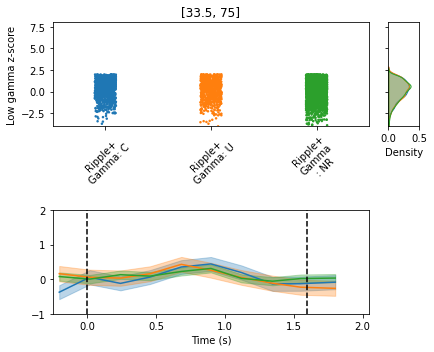

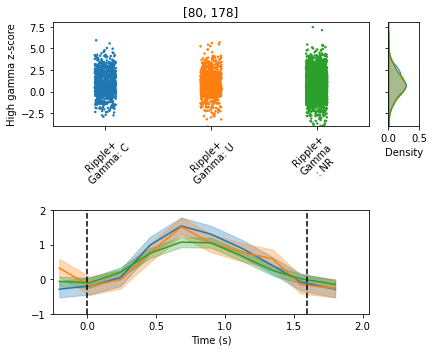

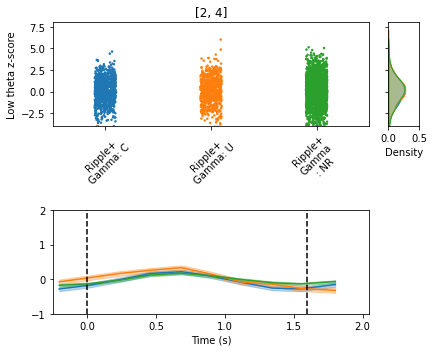

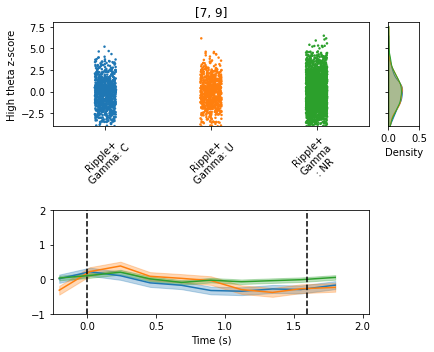

In [63]:
# Set the time range for x-axis for mean over time (ripple_time_range handles the time range for the swarm)
time_bins = np.linspace(-0.2, 2.0, 100)  # 100 bins from -0.2 to 2.0 seconds
swarm_ylimits = [-4.0, 8.0]
mean_ylimits = [-1.0, 2.0]

clust = dd_trials['clust_int'][sub_idxs]

# Define a consistent color palette
palette = {
    'Clustered': '#1f77b4',  # Blue
    'Unclustered': '#ff7f0e',  # Orange
    'Not Recalled': '#2ca02c'  # Green
}

for i_freq,freq_range in enumerate(freq_range_str_arr):

    if 29 < freq_range[0] < 35:
        ylabel = 'Low gamma z-score'
    elif 65 < freq_range[0] < 90:
        ylabel = 'High gamma z-score' 
    elif 1 < freq_range[0] < 3:
        ylabel = 'Low theta z-score'
    elif 6 < freq_range[0] < 8:
        ylabel = 'High theta z-score'

    # Extract the data for each group
    swarm_two_idx = ripple_trials & ~z_low_gamma_trials  # Retain only the middle row (Ripple (yes low gamma))

    # Apply the clust variable to split data into clustered, unclustered, and not recalled
    clust_clustered = clust > 1
    clust_unclustered = clust < 0
    clust_not_recalled = clust == 0

    # Combine the data for swarm two (Ripple (yes low gamma))
    swarm_two_clustered = sub_Zs[i_freq, swarm_two_idx & clust_clustered, ripple_time_range].mean(axis=1)
    swarm_two_unclustered = sub_Zs[i_freq, swarm_two_idx & clust_unclustered, ripple_time_range].mean(axis=1)
    swarm_two_not_recalled = sub_Zs[i_freq, swarm_two_idx & clust_not_recalled, ripple_time_range].mean(axis=1)

    # Combine the data into a single array for swarm plots
    data_combined = np.concatenate([swarm_two_clustered, swarm_two_unclustered, swarm_two_not_recalled])

    # Create simplified labels for each group
    labels = (['Ripple+\nGamma: C'] * len(swarm_two_clustered) +
              ['Ripple+\nGamma: U'] * len(swarm_two_unclustered) +
              ['Ripple+\nGamma\n: NR'] * len(swarm_two_not_recalled))

    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(6, 5))  # Adjusted figure size
    gs = gridspec.GridSpec(2, 4, height_ratios=[2, 2], width_ratios=[3,3,3,1])  # 4th column for kde

    # Create the swarmplot (span all columns)
    ax_swarm = fig.add_subplot(gs[0, :3])
    sb.stripplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], size=2.5, jitter=True)

    ax_swarm.set_ylabel(ylabel)
    ax_swarm.set_xlabel('')
    ax_swarm.set_ylim(swarm_ylimits)
    ax_swarm.set_title(freq_range)  # unique_subs[patient_idx])
    ax_swarm.set_xticklabels(ax_swarm.get_xticklabels(), rotation=45, ha="center")

    # Add the KDE plot to the right of the strip plots
    ax_kde = fig.add_subplot(gs[0, 3])

    # Plot KDE for each category separately
    sb.kdeplot(y=swarm_two_clustered, ax=ax_kde, color=palette['Clustered'], fill=True, label='Clustered')
    sb.kdeplot(y=swarm_two_unclustered, ax=ax_kde, color=palette['Unclustered'], fill=True, label='Unclustered')
    sb.kdeplot(y=swarm_two_not_recalled, ax=ax_kde, color=palette['Not Recalled'], fill=True, label='Not Recalled')

    ax_kde.set_ylim(-4, 8)  # Adjust limits based on your data
    ax_kde.set_xlabel('Density')
    ax_kde.set_ylabel('')  # Remove ylabel
    ax_kde.set_yticklabels('') #([0, 0.5, 1])  # Set the desired tick positions
    ax_kde.set_xlabel('Density')  # Add label to the bottom of the KDE plot
    ax_kde.set_xticks([0, 0.5, 1])  # Set the desired tick positions
    ax_kde.set_xlim(0,0.5)  # Set the corresponding labels    
#     ax_kde.legend()  # Optional: Add a legend for the lines

    
    # Function to calculate mean and SE
    def mean_and_se(data):
        mean = data.mean(axis=0)
        se = data.std(axis=0) / np.sqrt(data.shape[0])
        return mean, se

    # Decimate time bins
    decimation_factor = 10
    time_bins_decimated = decimate(time_bins, decimation_factor)
    plot_time_range_decimated = slice(None, None, decimation_factor)

    # Plot for swarm two
    mean_swarm_two_clustered, se_swarm_two_clustered = mean_and_se(sub_Zs[i_freq, swarm_two_idx & clust_clustered, plot_time_range])
    mean_swarm_two_unclustered, se_swarm_two_unclustered = mean_and_se(sub_Zs[i_freq, swarm_two_idx & clust_unclustered, plot_time_range])
    mean_swarm_two_not_recalled, se_swarm_two_not_recalled = mean_and_se(sub_Zs[i_freq, swarm_two_idx & clust_not_recalled, plot_time_range])

    ax_swarm_two = fig.add_subplot(gs[1, :3])  # Only one plot here
    ax_swarm_two.plot(time_bins_decimated, decimate(mean_swarm_two_clustered, decimation_factor), label='Clustered', color=palette['Clustered'])
    ax_swarm_two.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_two_clustered, decimation_factor) - decimate(se_swarm_two_clustered, decimation_factor),
                              decimate(mean_swarm_two_clustered, decimation_factor) + decimate(se_swarm_two_clustered, decimation_factor), 
                              alpha=0.3, color=palette['Clustered'])
    ax_swarm_two.plot(time_bins_decimated, decimate(mean_swarm_two_unclustered, decimation_factor), label='Unclustered', color=palette['Unclustered'])
    ax_swarm_two.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_two_unclustered, decimation_factor) - decimate(se_swarm_two_unclustered, decimation_factor),
                              decimate(mean_swarm_two_unclustered, decimation_factor) + decimate(se_swarm_two_unclustered, decimation_factor), 
                              alpha=0.3, color=palette['Unclustered'])
    ax_swarm_two.plot(time_bins_decimated, decimate(mean_swarm_two_not_recalled, decimation_factor), label='Not Recalled', color=palette['Not Recalled'])
    ax_swarm_two.fill_between(time_bins_decimated, 
                              decimate(mean_swarm_two_not_recalled, decimation_factor) - decimate(se_swarm_two_not_recalled, decimation_factor),
                              decimate(mean_swarm_two_not_recalled, decimation_factor) + decimate(se_swarm_two_not_recalled, decimation_factor), 
                              alpha=0.3, color=palette['Not Recalled'])
    ax_swarm_two.axvline(x=0.0, color='black', linestyle='--')
    ax_swarm_two.axvline(x=1.6, color='black', linestyle='--')
    ax_swarm_two.set_xlabel('Time (s)')
    ax_swarm_two.set_xlim(-0.25, 2.05)
    ax_swarm_two.set_ylim(mean_ylimits)

    # Adjust layout to ensure the plots align correctly
    plt.tight_layout(h_pad=2)
    plt.show()
a=1;

In [11]:
sum(~ripple_trials & z_high_gamma_trials)
sum(~ripple_trials & z_low_gamma_trials)
sum(~ripple_trials & z_low_gamma_trials & z_high_gamma_trials)
sum(ripple_trials & z_low_gamma_trials)
sum(ripple_trials & z_low_gamma_trials & z_high_gamma_trials)

1047

1004

317

985

541

In [12]:
sum(ripple_trials & z_high_gamma_trials)
sum(z_low_gamma_trials & ripple_trials)
sum(z_low_gamma_trials & z_high_gamma_trials)
sum(~ripple_trials & z_high_gamma_trials)
sum(z_low_gamma_trials & ~ripple_trials)
sum(z_low_gamma_trials & ~z_high_gamma_trials)

1518

985

858

1047

1004

1131

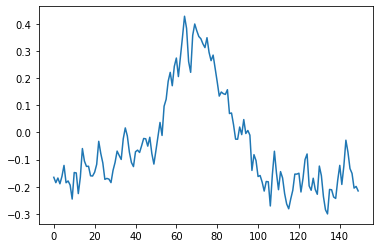

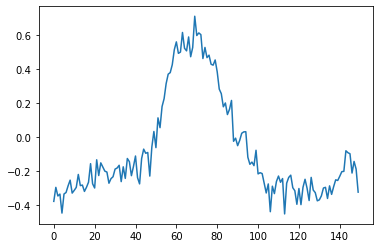

In [13]:
for pp in range(2):
    plt.plot(np.mean(power_z[pp,:,50:200],0))
    plt.show() 
    

# Ebrahim's combo of HFA/theta figures

In [14]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    ### clust key ###
    # -2: dead end, -1 remote unclustered, 0 not recalled, 
    # +1 temporal adjacent, +2 remote semantic, +3 adjacent semantic    
    #################
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
    
    # times relative to -1.7 to 3.3 s from word_on
#     start_time = 
    for power_z, ylabel in load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,
                                              high_fq_range, low_fq_range):

        if len(subregion[0]) > 0:
            subregion_str = f'_{subregion[0]}'
        else:
            subregion_str = ''
            
        if 'Gamma' in ylabel:
            fq_range = high_fq_range
        elif 'Theta' in ylabel:
            fq_range = low_fq_range
    
        # loop through sub-bands of gamma or theta
        for power_z_i, f in zip(power_z, fq_range): 

            plt.figure(figsize=(10,6))

            # Calculate mean and SEM
            mean_clust = np.mean(power_z_i[clust_idxs].squeeze(), axis=0)
            mean_not_clust = np.mean(power_z_i[notclust_idxs].squeeze(), axis=0)
            sem_clust = np.std(power_z_i[clust_idxs].squeeze(), axis=0) / np.sqrt(len(clust_idxs))
            sem_not_clust = np.std(power_z_i[notclust_idxs].squeeze(), axis=0) / np.sqrt(len(notclust_idxs))
            
            # Apply smoothing
            mean_clust_smooth = triangleSmooth(mean_clust, smoothing_triangle=5)
            mean_not_clust_smooth = triangleSmooth(mean_not_clust, smoothing_triangle=5)
            sem_clust_smooth = triangleSmooth(sem_clust, smoothing_triangle=5)
            sem_not_clust_smooth = triangleSmooth(sem_not_clust, smoothing_triangle=5)

            # Plotting
            plt.plot(time, mean_clust_smooth, color='tab:blue', alpha=0.8, label="Clust")
            plt.plot(time, mean_not_clust_smooth, color='tab:orange', alpha=0.8, label="Not Clust")
            
            if plot_error_bars:
                plt.fill_between(time, mean_clust_smooth - sem_clust_smooth, mean_clust_smooth + sem_clust_smooth, 
                                 color='tab:blue', alpha=0.3)
                plt.fill_between(time, mean_not_clust_smooth - sem_not_clust_smooth, mean_not_clust_smooth + sem_not_clust_smooth,
                                 color='tab:orange', alpha=0.3)
                
            # plot not recalled data for encoding 
            if encoding_mode:
                mean_not_recalled = np.mean(power_z_i[incorrect_idxs].squeeze(), axis=0)
                mean_not_recalled_smooth = triangleSmooth(mean_not_recalled, smoothing_triangle=5)
                
                sem_not_recalled = np.std(power_z_i[incorrect_idxs].squeeze(), axis=0) / np.sqrt(len(incorrect_idxs))
                sem_not_recalled_smooth = triangleSmooth(sem_not_recalled, smoothing_triangle=5)
                                                    
                plt.plot(time, mean_not_recalled_smooth, color='tab:pink', alpha=0.8, label="Not Recalled")
                
                if plot_error_bars:
                    plt.fill_between(time, mean_not_recalled - sem_not_recalled_smooth, 
                                     mean_not_recalled + sem_not_recalled_smooth, color='tab:pink', alpha=0.3)
                

            plt.axvline(0, color='black')
            plt.ylabel(f"{ylabel} ({f[0]}-{f[1]} Hz)", fontsize=18)
            plt.xlabel("Time", fontsize=18)
            sb.despine()
            plt.legend(fontsize=16)
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}", dpi=300, 
                        bbox_inches='tight')
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}.pdf",
                        bbox_inches='tight')
            plt.show()
a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


NameError: name 'high_fq_range' is not defined

In [ ]:
plt.plot(np.mean(filtered_sig_power[2, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[1, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[0, selected_elec_idxs].squeeze(),axis=0))
plt.show()


In [ ]:
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from mne.time_frequency import tfr_array_morlet
from neurodsp.plts import plot_time_series, plot_timefrequency

In [ ]:
frequencies_low = [1,2,3,4,5,6,7,8,9,10]
frequencies_high = np.arange(10,156,5)
frequencies = np.hstack((frequencies_low, frequencies_high))
n_freqs = frequencies.shape[0]
n_cycles = np.floor(np.linspace(2,15,n_freqs))

In [ ]:
# Define general settings for across the example
for selected_elec in np.unique(subj_elec_sess_labels):
    print(selected_elec)
    #selected_elec = best_power_elec
    selected_elec_idxs = np.argwhere(subj_elec_sess_labels==selected_elec)
    raw_data_elec = raw_data[selected_elec_idxs].squeeze()
    fs = 500

    buffer = 500

    power_elec = tfr_array_morlet(np.expand_dims(raw_data_elec, axis=1), sfreq=500, 
                                  freqs=frequencies, output='power', n_cycles=n_cycles)
    mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

    # Define the baseline period as -500 ms to -100 ms 
    baseline_pow = np.mean(mwt[:, 100:300],axis=1)

    mwt = mwt/np.expand_dims(baseline_pow,axis=1)

    mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

    # plot data from 0 - 1500 ms 
    times = np.linspace(0,1.5,750)
    plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
    plt.colorbar(label='Baseline Normalized Power (dB)')
    plt.xlabel("Time after word onset (sec)", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)
    plt.title(selected_elec, fontsize=16)
    plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
    plt.close()

In [ ]:
power_elec = tfr_array_morlet(np.expand_dims(raw_data, axis=1), sfreq=500, 
                              freqs=frequencies, output='power', n_cycles=n_cycles)
mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

# Define the baseline period as -500 ms to -100 ms 
baseline_pow = np.mean(mwt[:, 100:300],axis=1)

mwt = mwt/np.expand_dims(baseline_pow,axis=1)

mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

# plot data from 0 - 1500 ms 
times = np.linspace(0,1.5,750)
plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
plt.colorbar(label='Baseline Normalized Power (dB)')
plt.xlabel("Time after word onset (sec)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)
plt.title(selected_elec, fontsize=16)
plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
plt.close()

In [ ]:
# Create a mask where True indicates values above the threshold
significant_mask = mwt_decibal > 0.5

# Plot the significant mask
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, len(frequencies), 10), frequencies[::10]) 
plt.imshow(significant_mask, aspect='auto', origin='lower')
plt.show()


In [ ]:
# Store the results
Pxx_base_list = []
Pxx_list = []

fs = 500
nperseg = 256
n_trials = raw_data_elec.shape[0]

start_roi = 200
end_roi = 1200
baseline_start = -700
baseline_end = 300

sr_factor = 1000 / fs
# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

# convert to indices based on start time and sampling rate factor
baseline_start_idx = int((baseline_start - start_time)/sr_factor)
baseline_end_idx = int((baseline_end - start_time)/sr_factor)

nperseg = int(end_idx - start_idx)
nperseg_base = int(baseline_end_idx - baseline_start_idx)

for trial in range(n_trials):
    f, Pxx = welch(raw_data_elec[trial, start_idx:end_idx], 
                   fs=fs, nperseg=nperseg)
    f_base, Pxx_base = welch(raw_data_elec[trial, baseline_start_idx:baseline_end_idx], 
                   fs=fs, nperseg=nperseg_base)

    Pxx_list.append(Pxx)
    Pxx_base_list.append(Pxx_base)
    

Pxx_array = np.array(Pxx_list)
Pxx_base_array = np.array(Pxx_base_list)

Pxx_mean = np.mean(Pxx_array, axis=0)
Pxx_base_mean = np.mean(Pxx_base_array, axis=0)


# Plot the averaged periodogram
plt.figure()
plt.semilogy(f, Pxx_mean)
plt.semilogy(f_base, Pxx_base_mean)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density [V^2/Hz]')
plt.title('Averaged Welch Periodogram')
plt.show()


In [ ]:
plot_end_idx = 119 # 170 Hz
Pxx_diff = Pxx_mean-Pxx_base_mean
Pxx_diff_mean = np.mean(Pxx_diff)
Pxx_diff_std = np.std(Pxx_diff)
plt.axhline(Pxx_diff_mean+Pxx_diff_std*2, color='black', alpha=0.6, linestyle='--')
plt.plot(f[:plot_end_idx], Pxx_diff[:plot_end_idx], linewidth=3)
plt.show()

In [ ]:
np.argwhere(f==max_freq_to_plot)

In [ ]:
# Initialize a model object
fm = FOOOF(peak_width_limits=[1.2,12], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.1,150]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f, Pxx_mean, freq_range)

In [ ]:
fs = 1  # Sampling frequency, adjust as per your data
nperseg = 1500  # Length of each segment

# Store the results
f_list = []
Pxx_list = []

for trial in range(n_trials):
    f, Pxx = welch(data[trial, :], fs=fs, nperseg=nperseg)
    f_list.append(f)
    Pxx_list.append(Pxx)

# Convert lists to numpy arrays for easier handling
f_array = np.array(f_list)
Pxx_array = np.array(Pxx_list)